# Solución al problema de Rutas de Vehículos aplicando GNN y CNN

## Librerias

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import torch
import torchvision
try:
   import torch_geometric
except:
   !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
   import torch_geometric

device = 'cuda' if torch.cuda.is_available() else 'cpu'

path = {"InstanciasMatrices": "Dataset/Instancias/matrices.npy",
        "InstanciasDemandas": "Dataset/Instancias/demandas.npy",
        "InstanciasCapacidades": "Dataset/Instancias/capacidades.npy",
        "aristasVRP": "Dataset/Targets/VRP/aristas.npy",
        "distanciasVRP": "Dataset/Targets/VRP/distancias.npy",
        "aristasCRP": "Dataset/Targets/CVRP/aristas.npy",
        "distanciasCVRP": "Dataset/Targets/CVRP/distancias.npy",
        "cargasCVRP": "Dataset/Targets/CVRP/cargas.npy",
        "FNNmodelVRP": "Models/VRP/FNN.pt",
        "FNNmodelCVRP": "Models/CVRP/FNN.pt",
        "CNNmodelVRP": "Models/VRP/CNN.pt",
        "CNNmodelCVRP": "Models/CVRP/CNN.pt",
        "GNNmodelVRP": "Models/VRP/GNN.pt",
        "GNNmodelCVRP": "Models/CVRP/GNN.pt"}

In [4]:
device

'cuda'

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#pathColab = "/content/drive/MyDrive/Solucion al problema de Rutas de vehiculos aplicando GNN y CNN"
#for k in path:
#   path[k] = pathColab + "/" + path[k]

## Carga del Dataset

### Instancias

#### Carga

In [7]:
matrices = np.load(path["InstanciasMatrices"])
demandas = np.load(path["InstanciasDemandas"])
capacidades = np.load(path["InstanciasCapacidades"])

#### Elementos a usar

In [8]:
numVehiculos = len(capacidades[0])
numNodos = matrices[0].shape[0]
numInstancias = matrices.shape[0]

vecNumVehiculos = np.array([numVehiculos]*numNodos).reshape((numNodos,1))
vecCapacidades = np.array([np.array([capacidades[i][0]]*numVehiculos*numNodos).reshape((numNodos, numVehiculos))
                           for i in range(numInstancias)])

def matrizAdyacenciaVRP(aristas):
   adjM = np.zeros((numNodos, numNodos))

   for i, j in aristas:
      adjM[i][j], adjM[j][i] = 1, 1
   
   return adjM

def matrizAdyacenciaCVRP(aristas):
   adjM = np.zeros((numNodos, numNodos))

   for i, j, k in aristas:
      adjM[i][j], adjM[j][i] = k, k
   
   return adjM

def generarGrafoVRP(Madj, targets):
   Madj = np.array(Madj, dtype=float)
   targets = targets.tolist()

   ind = np.triu_indices_from(Madj, k=1)

   ind1p = np.array([ind[0], ind[1], Madj[ind[0], ind[1]]]).T.tolist()
   ind2p = np.array([ind[1], ind[0], Madj[ind[1], ind[0]]]).T.tolist()

   larp = ind1p + ind2p
   
   lar = np.array(larp)
   lar = lar[:,:2].tolist()
   
   dar = {}
   for i, ari in enumerate(lar):
      dar[str(ari)] = i

   labels = np.zeros(len(lar)).tolist()
   for ari in targets:
      if(ari[0] == ari[1]):
         continue
      labels[dar["["+str(float(ari[0]))+", "+str(float(ari[1]))+"]"]] = 1.0

   lno = [(i, {"x": [float(i), float(numVehiculos)]}) for i in range(numNodos)]

   G = nx.DiGraph()
   G.add_weighted_edges_from(larp)
   G.add_nodes_from(lno)

   return G, labels

def generarGrafoCVRP(Madj, targets, demandas, capacidades):
   Madj = np.array(Madj, dtype=float)
   targets = targets.tolist()
   capacidades = np.array(capacidades, dtype=float).tolist()

   ind = np.triu_indices_from(Madj, k=1)

   ind1p = np.array([ind[0], ind[1], Madj[ind[0], ind[1]]]).T.tolist()
   ind2p = np.array([ind[1], ind[0], Madj[ind[1], ind[0]]]).T.tolist()

   larp = ind1p + ind2p
   
   lar = np.array(larp)
   lar = lar[:,:2].tolist()
   
   dar = {}
   for i, ari in enumerate(lar):
      dar[str(ari)] = i

   labels = np.zeros(len(lar)).tolist()
   for ari in targets:
      if(ari[0] == ari[1]):
         continue
      labels[dar["["+str(float(ari[0]))+", "+str(float(ari[1]))+"]"]] = 1.0

   lno = [(i, {"x": [float(demandas[i])] + capacidades}) for i in range(numNodos)]

   G = nx.DiGraph()
   G.add_weighted_edges_from(larp)
   G.add_nodes_from(lno)

   return G, labels

#### Cantidad

In [9]:
numInstancias

10000

### Target

#### VRP

##### Carga

In [10]:
aristasVRP = np.load(path["aristasVRP"])
distanciasVRP = np.load(path["distanciasVRP"])

##### Cantidad

In [11]:
aristasVRP.shape[0]

10000

##### Cantidad de problemas sin solución

In [12]:
ls = []
for i in range(aristasVRP.shape[0]):
   if(not all((aristasVRP[i] == np.zeros((30, 2))).tolist())):
      ls.append(i)
len(ls)

0

##### Ejemplo

Grafo solución de una instancia

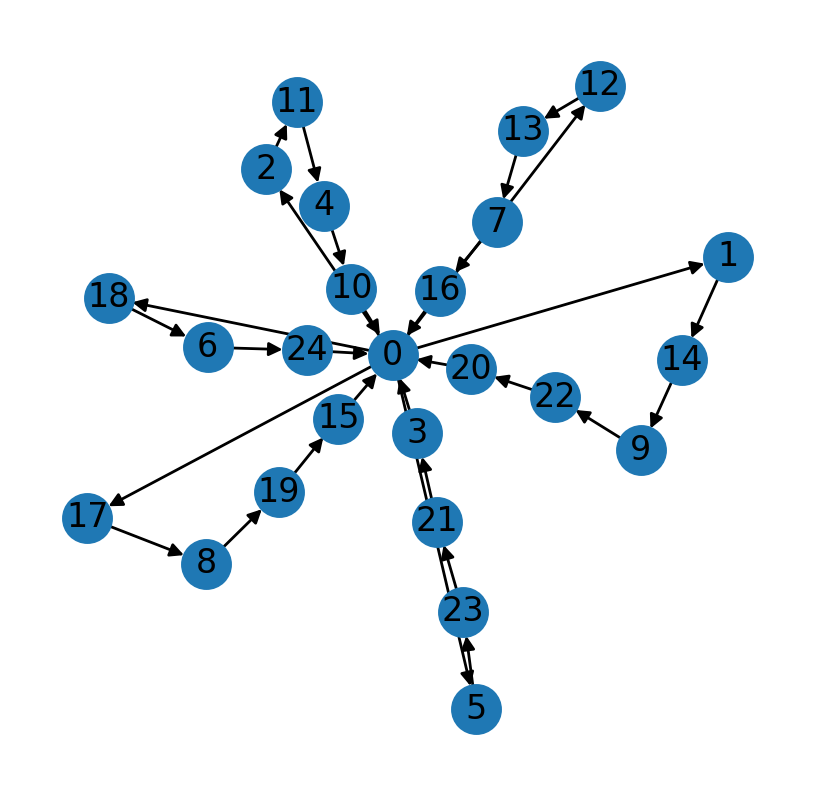

In [13]:
fig = plt.figure(dpi=200, figsize=(5,5))
limits = plt.axis("off")
G = nx.DiGraph()
G.add_edges_from(aristasVRP[2])
nx.draw_networkx(G)
plt.show()

#### CVRP

##### Carga

In [14]:
aristasCVRP = np.load(path["aristasCRP"])
distanciasCVRP = np.load(path["distanciasCVRP"])
cargasCVRP = np.load(path["cargasCVRP"])

##### Cantidad

In [15]:
aristasCVRP.shape[0]

10000

##### Cantidad de problemas sin solución

In [16]:
ls = []
for i in range(aristasCVRP.shape[0]):
   if(not all((aristasCVRP[i] == np.zeros((30, 3))).tolist())):
      ls.append(i)
len(ls)

0

##### Ejemplo

Grafo solución de una instancia

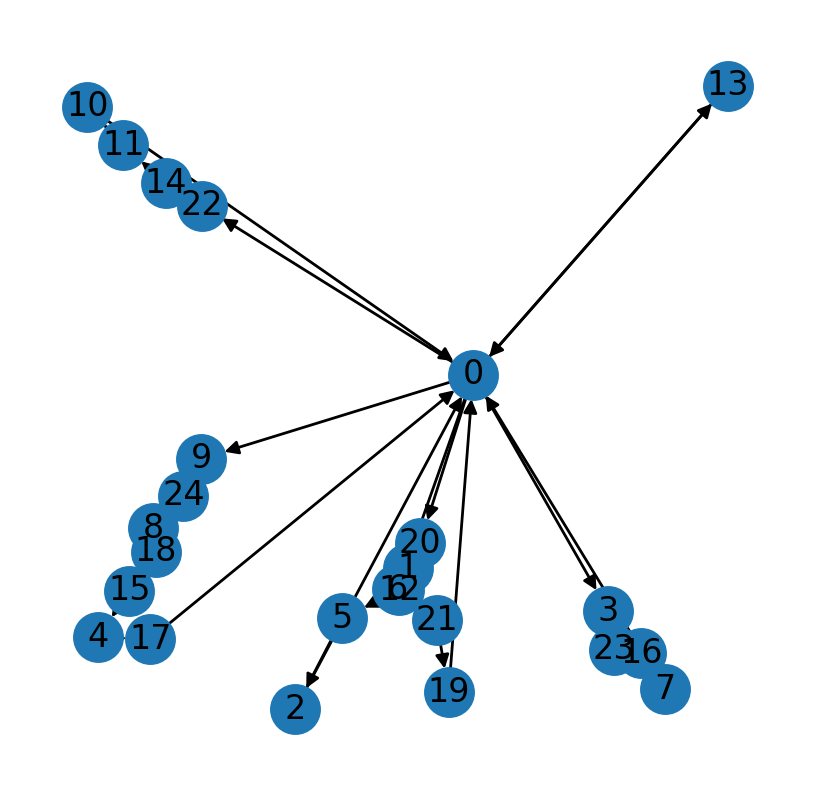

In [16]:
fig = plt.figure(dpi=200, figsize=(5,5))
limits = plt.axis("off")
G = nx.DiGraph()
G.add_weighted_edges_from(aristasCVRP[19])
nx.draw_networkx(G)
plt.show()

## Modelos

### Feed-Forward Neural Network

#### Tratamiento de datos

Partición del dataset en train y test

##### VRP

In [ ]:
X_VRP = np.array([np.concatenate((matrices[i], vecNumVehiculos), axis=1) 
                  for i in range(numInstancias)])
y_VRP = np.array([matrizAdyacenciaVRP(ari)
                  for ari in aristasVRP])
y_VRP = np.array([M[np.triu_indices_from(M, k=1)]
                  for M in y_VRP])

X_trainVRP, X_testVRP, y_trainVRP, y_testVRP = train_test_split(X_VRP, y_VRP, test_size=0.25, random_state=1)

dimensionX_VRP = X_trainVRP[0].shape[0]*X_trainVRP[0].shape[1]
dimensiony_VRP = y_trainVRP[0].shape[0]

##### CVRP

In [ ]:
X_CVRP = np.array([np.concatenate((matrices[i], vecNumVehiculos, demandas[i].reshape((l, 1)), vecCapacidades[i]), axis=1) 
                  for i in range(numInstancias)])
y_CVRP = np.array([matrizAdyacenciaCVRP(ari)
                  for ari in aristasCVRP])
y_CVRP = np.array([M[np.triu_indices_from(M, k=1)]
                  for M in y_CVRP])

X_trainCVRP, X_testCVRP, y_trainCVRP, y_testCVRP = train_test_split(X_CVRP, y_CVRP, test_size=0.25, random_state=1)

dimensionX_CVRP = X_trainCVRP[0].shape[0]*X_trainCVRP[0].shape[1]
dimensiony_CVRP = y_trainCVRP[0].shape[0]

#### Crear Dataset especifico para el modelo

Creación de la clase Dataset para la manipulación de los datos

In [ ]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self, X, y):
      self.X = torch.from_numpy(X/1500).float().cuda().view(-1, X[0].shape[0]*X[0].shape[1])
      self.y = torch.from_numpy(y/8).float().cuda()
   def __len__(self):
      return len(self.X)
   def __getitem__(self, ix):
      return self.X[ix], self.y[ix]

In [ ]:
datasetVRP = {
   'train': Dataset(X_trainVRP, y_trainVRP),
   'test': Dataset(X_testVRP, y_testVRP),
}

datasetCVRP = {
   'train': Dataset(X_trainCVRP, y_trainCVRP),
   'test': Dataset(X_testCVRP, y_testCVRP),
}

Se divide el dataset en batches para un mejor entrenamiento usando el modulo utils.data.

In [ ]:
dataloaderVRP = {
   'train': torch.utils.data.DataLoader(datasetVRP['train'], batch_size=20, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetVRP['test'], batch_size=20, shuffle=False)
}

dataloaderCVRP = {
   'train': torch.utils.data.DataLoader(datasetCVRP['train'], batch_size=20, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetCVRP['test'], batch_size=20, shuffle=False)
}

#### Definición del modelo

In [ ]:
class FNN(torch.nn.Module):
   def __init__(self, D_in, H, D_out):
      super().__init__()
      self.fc1 = torch.nn.Sequential(
                    torch.nn.Linear(D_in, H),
                    torch.nn.ReLU()
                 )
      self.fc2 = torch.nn.Sequential(
                    torch.nn.Linear(H, 2*H),
                    torch.nn.ReLU()
                 )
      self.fc3 = torch.nn.Sequential(
                    torch.nn.Linear(2*H, 2*H),
                    torch.nn.ReLU()
                 )
      self.fc4 = torch.nn.Sequential(
                    torch.nn.Linear(2*H, H),
                    torch.nn.ReLU()
                 )
      self.fc5 = torch.nn.Sequential(
                    torch.nn.Linear(H, D_out),
                    torch.nn.ReLU()
                 )
   
   def forward(self, x):
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x = self.fc4(x)
      x = self.fc5(x)
      return x

#### Función de entrenamiento

In [ ]:
def fit(model, dataloader, epochs):
   model.to(device)
   optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.2)
   criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
   FNNTrainLossMean, FNNValLossMean, FNNTrainEVSMean, FNNValEVSMean = [0.0], [0.0], [0.0], [0.0]
   for epoch in range(1, epochs+1):
      model.train()
      FNNTrainLoss, FNNTrainEVS = [], []
      batches = dataloader['train']
      for batch in batches:
         X, y = batch
         X, y = X.to(device), y.to(device)
         optimizer.zero_grad()
         y_hat = model(X)
         loss = criterion(torch.nn.functional.log_softmax(y_hat, dim=1), 
                          torch.nn.functional.log_softmax(y, dim=1))
         loss.backward()
         optimizer.step()
         FNNTrainLoss.append(loss.item())
         evs = explained_variance_score(y.detach().cpu().numpy(), torch.round(y_hat).detach().cpu().numpy(), multioutput='uniform_average')
         FNNTrainEVS.append(evs)
      batches = dataloader['test']
      FNNValLoss, FNNValEVS = [], []
      model.eval()
      with torch.no_grad():
         for batch in batches:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(torch.nn.functional.log_softmax(y_hat, dim=1),
                             torch.nn.functional.log_softmax(y, dim=1))
            FNNValLoss.append(loss.item())
            evs = explained_variance_score(y.cpu().numpy(), torch.round(y_hat).cpu().numpy(), multioutput='uniform_average')
            FNNValEVS.append(evs)
      scheduler.step()
      FNNTrainLossMean.append(np.mean(FNNTrainLoss))
      FNNValLossMean.append(np.mean(FNNValLoss))
      FNNTrainEVSMean.append(np.mean(FNNTrainEVS))
      FNNValEVSMean.append(np.mean(FNNValEVS))
      print(f"Epoch {epoch}/{epochs} loss {FNNTrainLossMean[-1]:.5f} val_loss {FNNValLossMean[-1]:.5f} EVS {FNNTrainEVSMean[-1]:.5f} val_EVS {FNNValEVSMean[-1]:.5f}")
   return FNNTrainLossMean, FNNValLossMean, FNNTrainEVSMean, FNNValEVSMean

#### VRP

##### Instanciación del modelo

In [ ]:
FNN_VRPmodel = FNN(dimensionX_VRP, 700, dimensiony_VRP)
FNN_VRPmodel

FNN(
  (fc1): Sequential(
    (0): Linear(in_features=650, out_features=700, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=700, out_features=1400, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=1400, out_features=1400, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=1400, out_features=700, bias=True)
    (1): ReLU()
  )
  (fc5): Sequential(
    (0): Linear(in_features=700, out_features=300, bias=True)
    (1): ReLU()
  )
)

##### Entrenamiento

In [ ]:
epochs = 30

FNNTrainLossVRP, FNNValLossVRP, FNNTrainEVSVRP, FNNValEVSVRP = fit(FNN_VRPmodel,
                                                                   dataloaderVRP,
                                                                   epochs=epochs)

Epoch 1/30 loss 21636.46199 val_loss 0.00143 EVS -570128953.55226 val_EVS 0.23941
Epoch 2/30 loss 0.00083 val_loss 0.00066 EVS 0.23694 val_EVS 0.23941
Epoch 3/30 loss 0.00066 val_loss 0.00066 EVS 0.23859 val_EVS 0.23941
Epoch 4/30 loss 0.00066 val_loss 0.00066 EVS 0.23643 val_EVS 0.23941
Epoch 5/30 loss 0.00066 val_loss 0.00066 EVS 0.23809 val_EVS 0.23941
Epoch 6/30 loss 0.00066 val_loss 0.00066 EVS 0.23962 val_EVS 0.23941
Epoch 7/30 loss 0.00066 val_loss 0.00066 EVS 0.23833 val_EVS 0.23941
Epoch 8/30 loss 0.00066 val_loss 0.00066 EVS 0.23758 val_EVS 0.23941
Epoch 9/30 loss 0.00066 val_loss 0.00066 EVS 0.23770 val_EVS 0.23941
Epoch 10/30 loss 0.00066 val_loss 0.00066 EVS 0.23797 val_EVS 0.23941
Epoch 11/30 loss 0.00066 val_loss 0.00066 EVS 0.23659 val_EVS 0.23941
Epoch 12/30 loss 0.00066 val_loss 0.00066 EVS 0.23759 val_EVS 0.23941
Epoch 13/30 loss 0.00066 val_loss 0.00066 EVS 0.23871 val_EVS 0.23941
Epoch 14/30 loss 0.00066 val_loss 0.00066 EVS 0.23630 val_EVS 0.23941
Epoch 15/30 loss

##### Gráficas de métricas

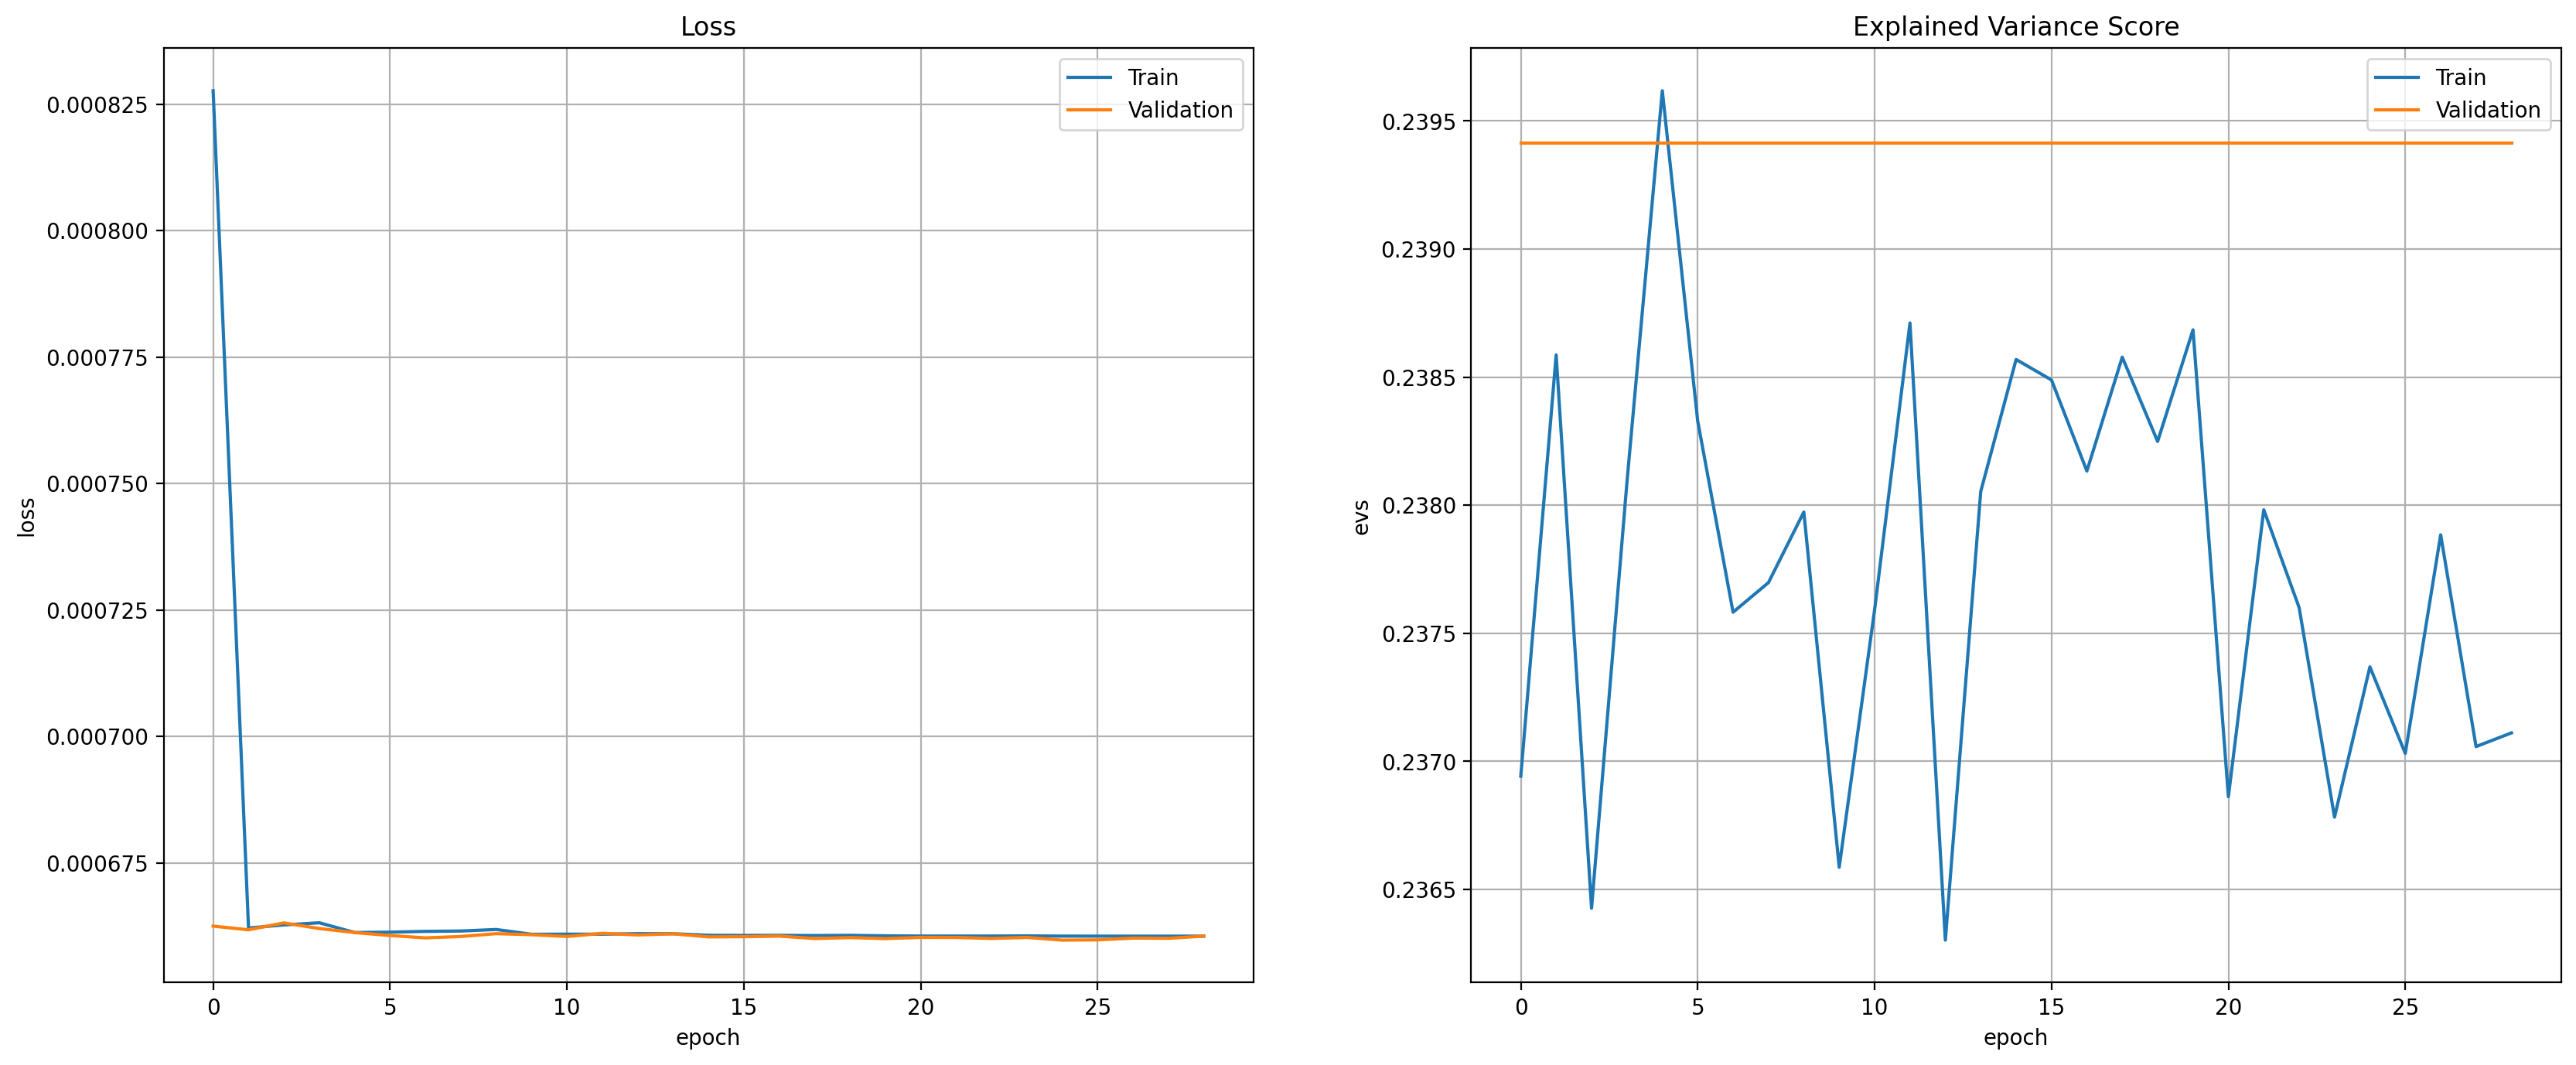

In [ ]:
fig = plt.figure(dpi=200, figsize=(20,8))
ax = plt.subplot(121)
ax.plot(FNNTrainLossVRP[2:], label="Train")
ax.plot(FNNValLossVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(FNNTrainEVSVRP[2:], label="Train")
ax.plot(FNNValEVSVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title("Explained Variance Score")
ax.set_ylabel('evs')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [ ]:
torch.save(FNN_VRPmodel.state_dict(), path["FNNmodelVRP"])

#### CVRP

##### Instanciación del modelo

In [ ]:
FNN_CVRPmodel = FNN(dimensionX_CVRP, 1200, dimensiony_CVRP)
FNN_CVRPmodel

FNN(
  (fc1): Sequential(
    (0): Linear(in_features=825, out_features=1200, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1200, out_features=2400, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=2400, out_features=2400, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=2400, out_features=1200, bias=True)
    (1): ReLU()
  )
  (fc5): Sequential(
    (0): Linear(in_features=1200, out_features=300, bias=True)
    (1): ReLU()
  )
)

##### Entrenamiento

In [ ]:
epochs = 20

FNNTrainLossCVRP, FNNValLossCVRP, FNNTrainEVSCVRP, FNNValEVSCVRP = fit(FNN_CVRPmodel,
                                                                       dataloaderCVRP,
                                                                       epochs=epochs)

Epoch 1/20 loss 147744.72704 val_loss 0.03222 EVS -18002390013.11282 val_EVS 0.21184
Epoch 2/20 loss 0.02837 val_loss 0.02581 EVS 0.20852 val_EVS 0.21184
Epoch 3/20 loss 0.02485 val_loss 0.02434 EVS 0.20898 val_EVS 0.21184
Epoch 4/20 loss 0.02385 val_loss 0.02394 EVS 0.20746 val_EVS 0.21184
Epoch 5/20 loss 0.02386 val_loss 0.02394 EVS 0.20956 val_EVS 0.21184
Epoch 6/20 loss 0.02386 val_loss 0.02394 EVS 0.20877 val_EVS 0.21184
Epoch 7/20 loss 0.02386 val_loss 0.02394 EVS 0.20949 val_EVS 0.21184
Epoch 8/20 loss 0.02386 val_loss 0.02394 EVS 0.20775 val_EVS 0.21184
Epoch 9/20 loss 0.02386 val_loss 0.02394 EVS 0.20938 val_EVS 0.21184
Epoch 10/20 loss 0.02386 val_loss 0.02394 EVS 0.20723 val_EVS 0.21184
Epoch 11/20 loss 0.02386 val_loss 0.02394 EVS 0.20713 val_EVS 0.21184
Epoch 12/20 loss 0.02386 val_loss 0.02394 EVS 0.20882 val_EVS 0.21184
Epoch 13/20 loss 0.02386 val_loss 0.02394 EVS 0.21028 val_EVS 0.21184
Epoch 14/20 loss 0.02386 val_loss 0.02394 EVS 0.20910 val_EVS 0.21184
Epoch 15/20 l

##### Gráficas de métricas

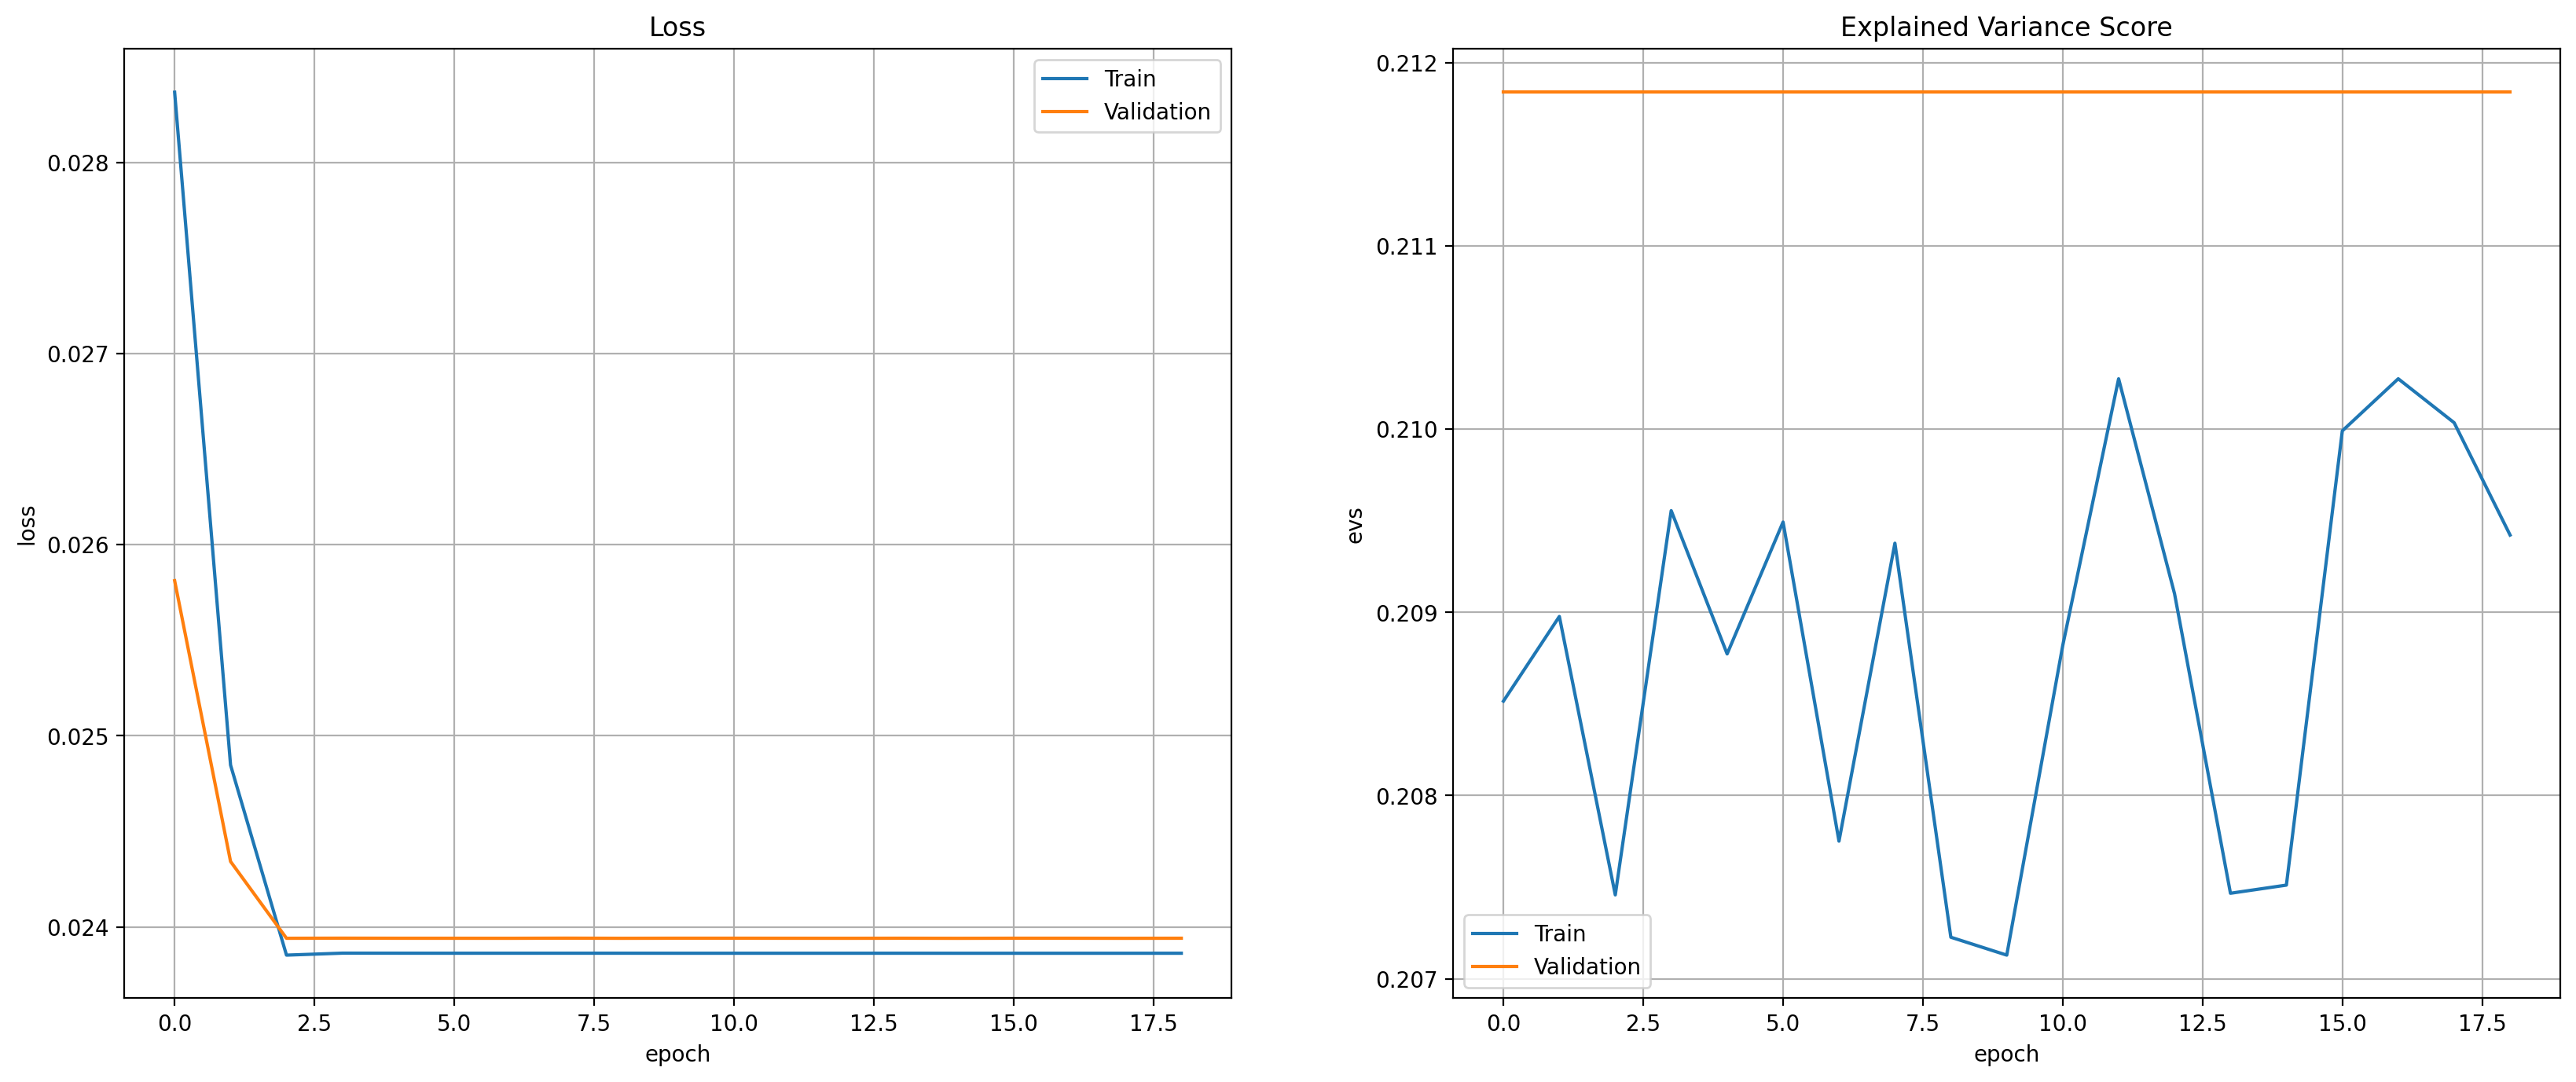

In [ ]:
fig = plt.figure(dpi=200, figsize=(20,8))
ax = plt.subplot(121)
ax.plot(FNNTrainLossCVRP[2:], label="Train")
ax.plot(FNNValLossCVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(FNNTrainEVSCVRP[2:], label="Train")
ax.plot(FNNValEVSCVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title("Explained Variance Score")
ax.set_ylabel('evs')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [ ]:
torch.save(FNN_CVRPmodel.state_dict(), path["FNNmodelCVRP"])

### Convolutional Neural Network

#### Tratamiento de datos

Partición del dataset en train y test

##### VRP

In [ ]:
X_VRP = np.array([np.concatenate((matrices[i], vecNumVehiculos), axis=1) 
                  for i in range(numInstancias)])
y_VRP = np.array([matrizAdyacenciaVRP(ari)
                  for ari in aristasVRP])
y_VRP = np.array([M[np.triu_indices_from(M, k=1)]
                  for M in y_VRP])

X_trainVRP, X_testVRP, y_trainVRP, y_testVRP = train_test_split(X_VRP, y_VRP, test_size=0.25, random_state=1)

dimensionX_VRP = X_trainVRP[0].shape[0]*X_trainVRP[0].shape[1]
dimensiony_VRP = y_trainVRP[0].shape[0]

##### CVRP

In [ ]:
X_CVRP = np.array([np.concatenate((matrices[i], vecNumVehiculos, demandas[i].reshape((l, 1)), vecCapacidades[i]), axis=1) 
                  for i in range(numInstancias)])
y_CVRP = np.array([matrizAdyacenciaCVRP(ari)
                  for ari in aristasCVRP])
y_CVRP = np.array([M[np.triu_indices_from(M, k=1)]
                  for M in y_CVRP])

X_trainCVRP, X_testCVRP, y_trainCVRP, y_testCVRP = train_test_split(X_CVRP, y_CVRP, test_size=0.25, random_state=1)

dimensionX_CVRP = X_trainCVRP[0].shape[0]*X_trainCVRP[0].shape[1]
dimensiony_CVRP = y_trainCVRP[0].shape[0]

#### Crear dataset especifico para el modelo

Creación de la clase Dataset para la manipulación de los datos

In [ ]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self, X, y):
      self.X = torch.from_numpy(X).float().cuda()
      self.y = torch.from_numpy(y/8).float().cuda()
   def __len__(self):
      return len(self.X)
   def __getitem__(self, ix):
      transformation = torchvision.transforms.Normalize(0, 1)
      Xtransformed = self.X[ix].unsqueeze(0)
      Xtransformed = transformation(Xtransformed)
      return Xtransformed, self.y[ix]

In [ ]:
datasetVRP = {
   'train': Dataset(X_trainVRP, y_trainVRP),
   'test': Dataset(X_testVRP, y_testVRP),
}

datasetCVRP = {
   'train': Dataset(X_trainCVRP, y_trainCVRP),
   'test': Dataset(X_testCVRP, y_testCVRP),
}

Se divide el dataset en batches para un mejor entrenamiento usando el modulo utils.data.

In [ ]:
dataloaderVRP = {
   'train': torch.utils.data.DataLoader(datasetVRP['train'], batch_size=20, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetVRP['test'], batch_size=20, shuffle=False)
}

dataloaderCVRP = {
   'train': torch.utils.data.DataLoader(datasetCVRP['train'], batch_size=20, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetCVRP['test'], batch_size=20, shuffle=False)
}

#### Definición del modelo

In [ ]:
class CNN(torch.nn.Module):
   def __init__(self, D_in, D_out):
      super().__init__()
      self.conv1 = torch.nn.Sequential(
                      torch.nn.Conv2d(1, 64, 3, padding=1, stride=1),
                      torch.nn.ReLU()
                   )
      self.conv2 = torch.nn.Sequential(
                      torch.nn.Conv2d(64, 128, 3, padding=1, stride=1),
                      torch.nn.MaxPool2d(3, padding=1, stride=1),
                      torch.nn.ReLU()
                   )
      self.conv3 = torch.nn.Sequential(
                      torch.nn.Conv2d(128, 256, 3, padding=1, stride=1),
                      torch.nn.ReLU()
                   )
      self.fc = torch.nn.Sequential(
                   torch.nn.Linear(256*D_in, D_out),
                   torch.nn.ReLU()
                )
   
   def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = x.view(x.shape[0], -1)
      x = self.fc(x)
      return x

#### Función de entrenamiento

In [ ]:
def fit(model, dataloader, epochs):
   model.to(device)
   optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.2)
   criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
   CNNTrainLossMean, CNNValLossMean, CNNTrainEVSMean, CNNValEVSMean = [0.0], [0.0], [0.0], [0.0]
   for epoch in range(1, epochs+1):
      model.train()
      CNNTrainLoss, CNNTrainEVS = [], []
      batches = dataloader['train']
      for batch in batches:
         X, y = batch
         X, y = X.to(device), y.to(device)
         optimizer.zero_grad()
         y_hat = model(X)
         loss = criterion(torch.nn.functional.log_softmax(y_hat, dim=1), 
                          torch.nn.functional.log_softmax(y, dim=1))
         loss.backward()
         optimizer.step()
         CNNTrainLoss.append(loss.item())
         evs = explained_variance_score(y.detach().cpu().numpy(), torch.round(y_hat).detach().cpu().numpy(), multioutput='uniform_average')
         CNNTrainEVS.append(evs)
      batches = dataloader['test']
      CNNValLoss, CNNValEVS = [], []
      model.eval()
      with torch.no_grad():
         for batch in batches:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(torch.nn.functional.log_softmax(y_hat, dim=1),
                             torch.nn.functional.log_softmax(y, dim=1))
            CNNValLoss.append(loss.item())
            evs = explained_variance_score(y.cpu().numpy(), torch.round(y_hat).cpu().numpy(), multioutput='uniform_average')
            CNNValEVS.append(evs)
      scheduler.step()
      CNNTrainLossMean.append(np.mean(CNNTrainLoss))
      CNNValLossMean.append(np.mean(CNNValLoss))
      CNNTrainEVSMean.append(np.mean(CNNTrainEVS))
      CNNValEVSMean.append(np.mean(CNNValEVS))
      print(f"Epoch {epoch}/{epochs} loss {CNNTrainLossMean[-1]:.5f} val_loss {CNNValLossMean[-1]:.5f} EVS {CNNTrainEVSMean[-1]:.5f} val_EVS {CNNValEVSMean[-1]:.5f}")
   return CNNTrainLossMean, CNNValLossMean, CNNTrainEVSMean, CNNValEVSMean

#### VRP

##### Instanciación del modelo

In [ ]:
CNN_VRPmodel = CNN(dimensionX_VRP, dimensiony_VRP)
CNN_VRPmodel

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=166400, out_features=300, bias=True)
    (1): ReLU()
  )
)

##### Entrenamiento

In [ ]:
epochs = 20

CNNTrainLossVRP, CNNValLossVRP, CNNTrainEVSVRP, CNNValEVSVRP = fit(CNN_VRPmodel,
                                                                   dataloaderVRP,
                                                                   epochs=epochs)

Epoch 1/20 loss 1082332.57736 val_loss 0.00065 EVS -104749824768199.29688 val_EVS 0.23941
Epoch 2/20 loss 0.00064 val_loss 0.00064 EVS 0.23731 val_EVS 0.23941
Epoch 3/20 loss 0.00064 val_loss 0.00064 EVS 0.23781 val_EVS 0.23941
Epoch 4/20 loss 0.00064 val_loss 0.00064 EVS 0.23852 val_EVS 0.23941
Epoch 5/20 loss 0.00064 val_loss 0.00064 EVS 0.23757 val_EVS 0.23941
Epoch 6/20 loss 0.00064 val_loss 0.00064 EVS 0.23652 val_EVS 0.23941
Epoch 7/20 loss 0.00064 val_loss 0.00064 EVS 0.23914 val_EVS 0.23941
Epoch 8/20 loss 0.00064 val_loss 0.00064 EVS 0.23709 val_EVS 0.23941
Epoch 9/20 loss 0.00064 val_loss 0.00064 EVS 0.23784 val_EVS 0.23941
Epoch 10/20 loss 0.00064 val_loss 0.00064 EVS 0.23766 val_EVS 0.23941
Epoch 11/20 loss 0.00063 val_loss 0.00063 EVS 0.23956 val_EVS 0.23941
Epoch 12/20 loss 0.00063 val_loss 0.00063 EVS 0.23635 val_EVS 0.23941
Epoch 13/20 loss 0.00064 val_loss 0.00063 EVS 0.23764 val_EVS 0.23941
Epoch 14/20 loss 0.00064 val_loss 0.00064 EVS 0.23879 val_EVS 0.23941
Epoch 15

##### Gráficas de métricas

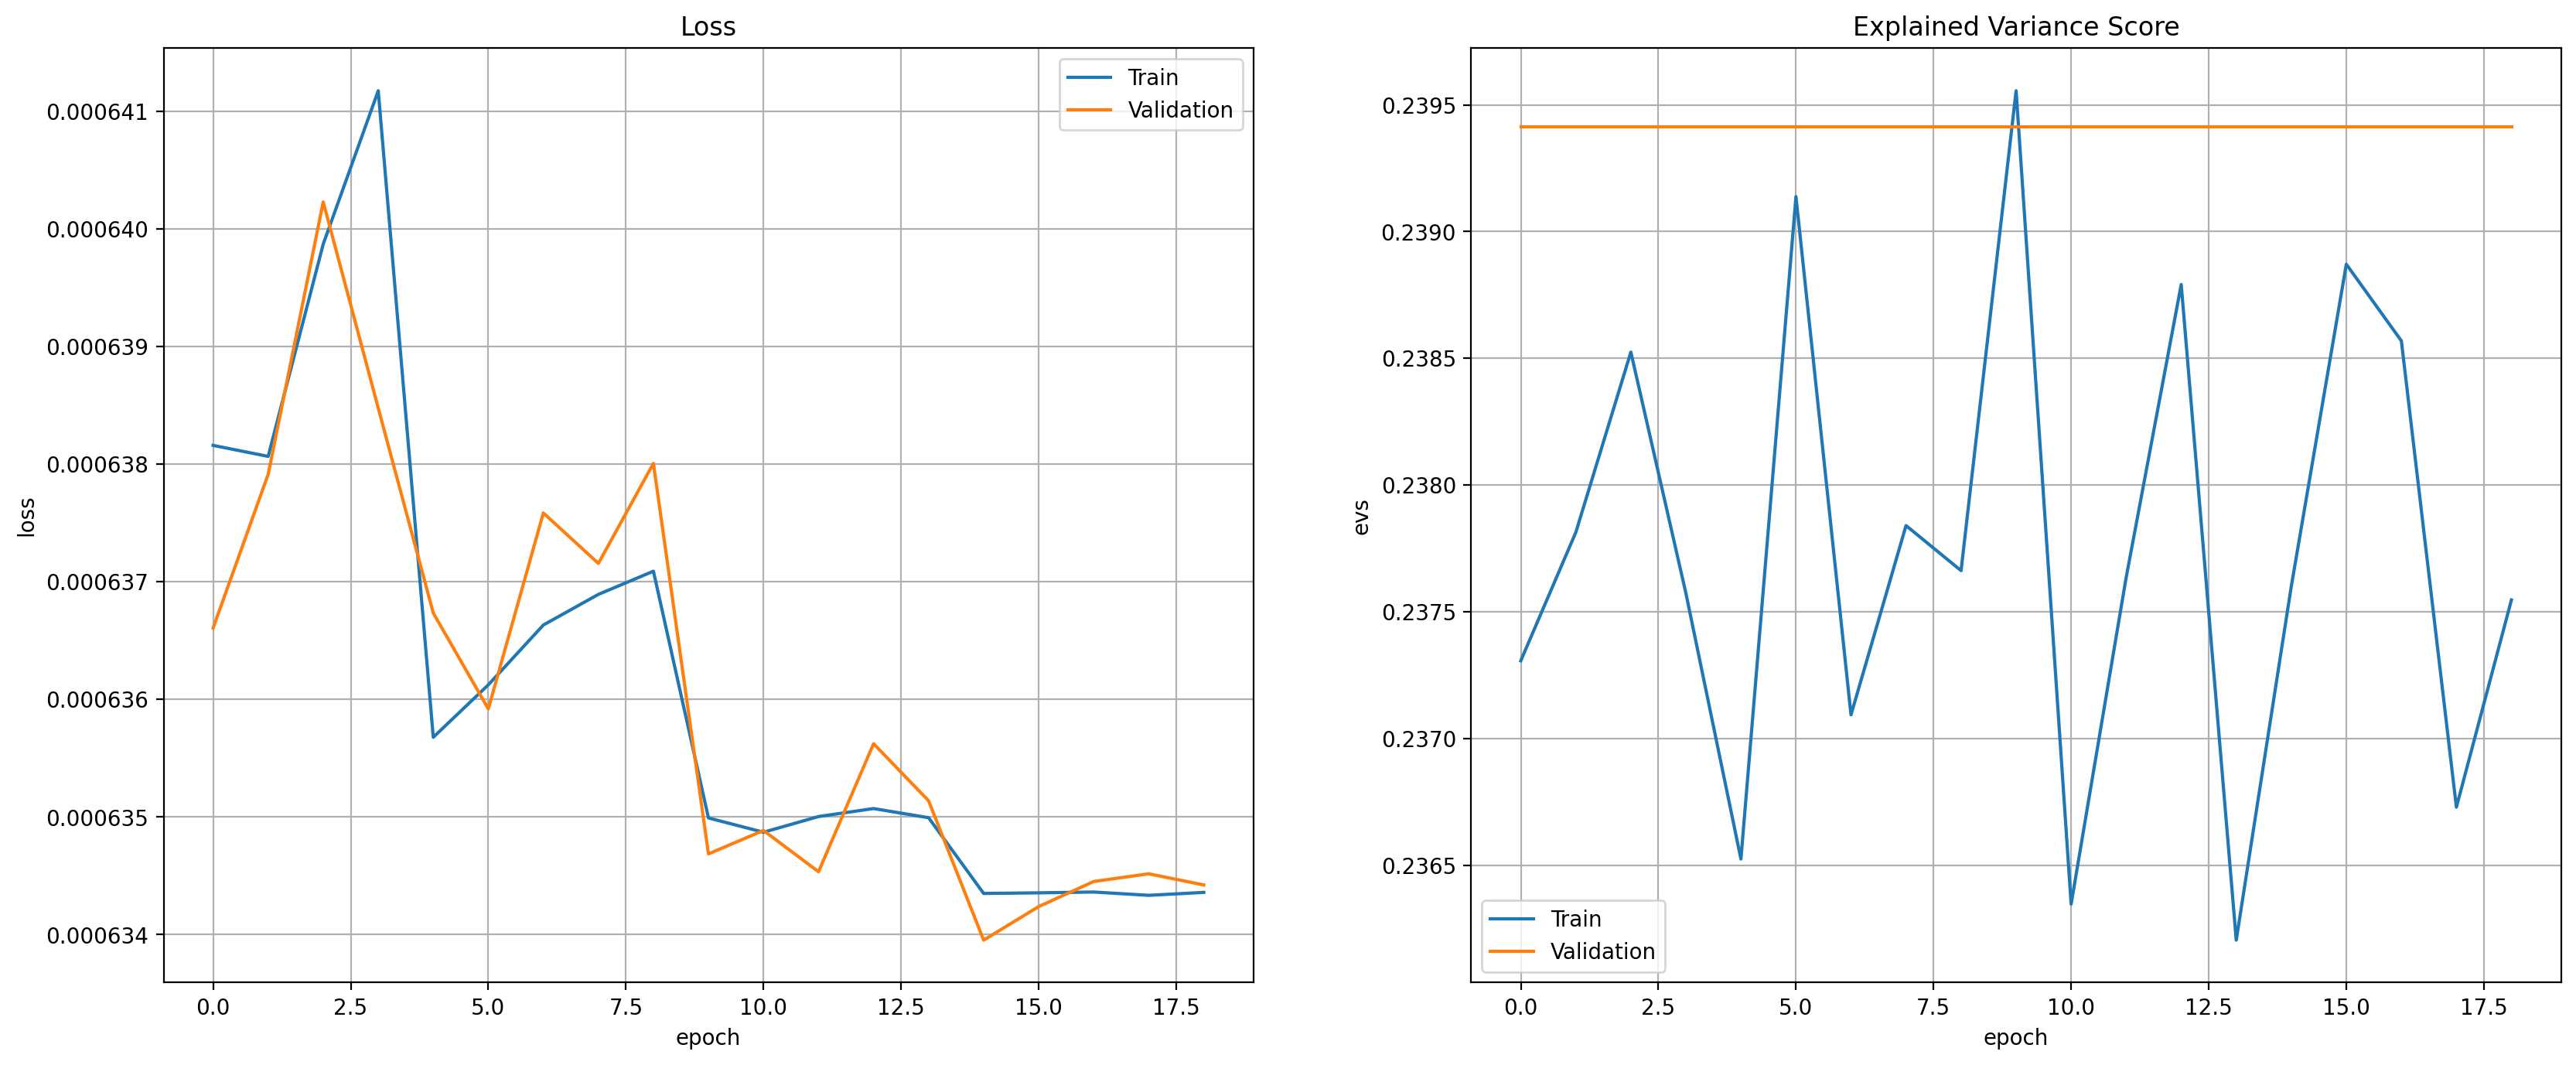

In [ ]:
fig = plt.figure(dpi=200, figsize=(20,8))
ax = plt.subplot(121)
ax.plot(CNNTrainLossVRP[2:], label="Train")
ax.plot(CNNValLossVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(CNNTrainEVSVRP[2:], label="Train")
ax.plot(CNNValEVSVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title("Explained Variance Score")
ax.set_ylabel('evs')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [ ]:
torch.save(CNN_VRPmodel.state_dict(), path["CNNmodelVRP"])

#### CVRP

##### Instanciación del modelo

In [ ]:
CNN_CVRPmodel = CNN(dimensionX_CVRP, dimensiony_CVRP)
CNN_CVRPmodel

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=211200, out_features=300, bias=True)
    (1): ReLU()
  )
)

##### Entrenamiento

In [ ]:
epochs = 20

CNNTrainLossCVRP, CNNValLossCVRP, CNNTrainEVSCVRP, CNNValEVSCVRP = fit(CNN_CVRPmodel,
                                                                       dataloaderCVRP,
                                                                       epochs=epochs)

Epoch 1/20 loss 959478.90873 val_loss 0.02390 EVS -21605450775098.66797 val_EVS 0.21184
Epoch 2/20 loss 0.02384 val_loss 0.02397 EVS 0.20884 val_EVS 0.21184
Epoch 3/20 loss 0.02389 val_loss 0.02398 EVS 0.20860 val_EVS 0.21184
Epoch 4/20 loss 0.02389 val_loss 0.02398 EVS 0.20719 val_EVS 0.21184
Epoch 5/20 loss 0.02390 val_loss 0.02398 EVS 0.20799 val_EVS 0.21184
Epoch 6/20 loss 0.02390 val_loss 0.02398 EVS 0.20827 val_EVS 0.21184
Epoch 7/20 loss 0.02390 val_loss 0.02398 EVS 0.20725 val_EVS 0.21184
Epoch 8/20 loss 0.02390 val_loss 0.02398 EVS 0.20905 val_EVS 0.21184
Epoch 9/20 loss 0.02390 val_loss 0.02398 EVS 0.20793 val_EVS 0.21184
Epoch 10/20 loss 0.02390 val_loss 0.02398 EVS 0.20724 val_EVS 0.21184
Epoch 11/20 loss 0.02390 val_loss 0.02398 EVS 0.20830 val_EVS 0.21184
Epoch 12/20 loss 0.02390 val_loss 0.02398 EVS 0.20761 val_EVS 0.21184
Epoch 13/20 loss 0.02390 val_loss 0.02398 EVS 0.20884 val_EVS 0.21184
Epoch 14/20 loss 0.02390 val_loss 0.02398 EVS 0.20804 val_EVS 0.21184
Epoch 15/2

##### Gráficas de métricas

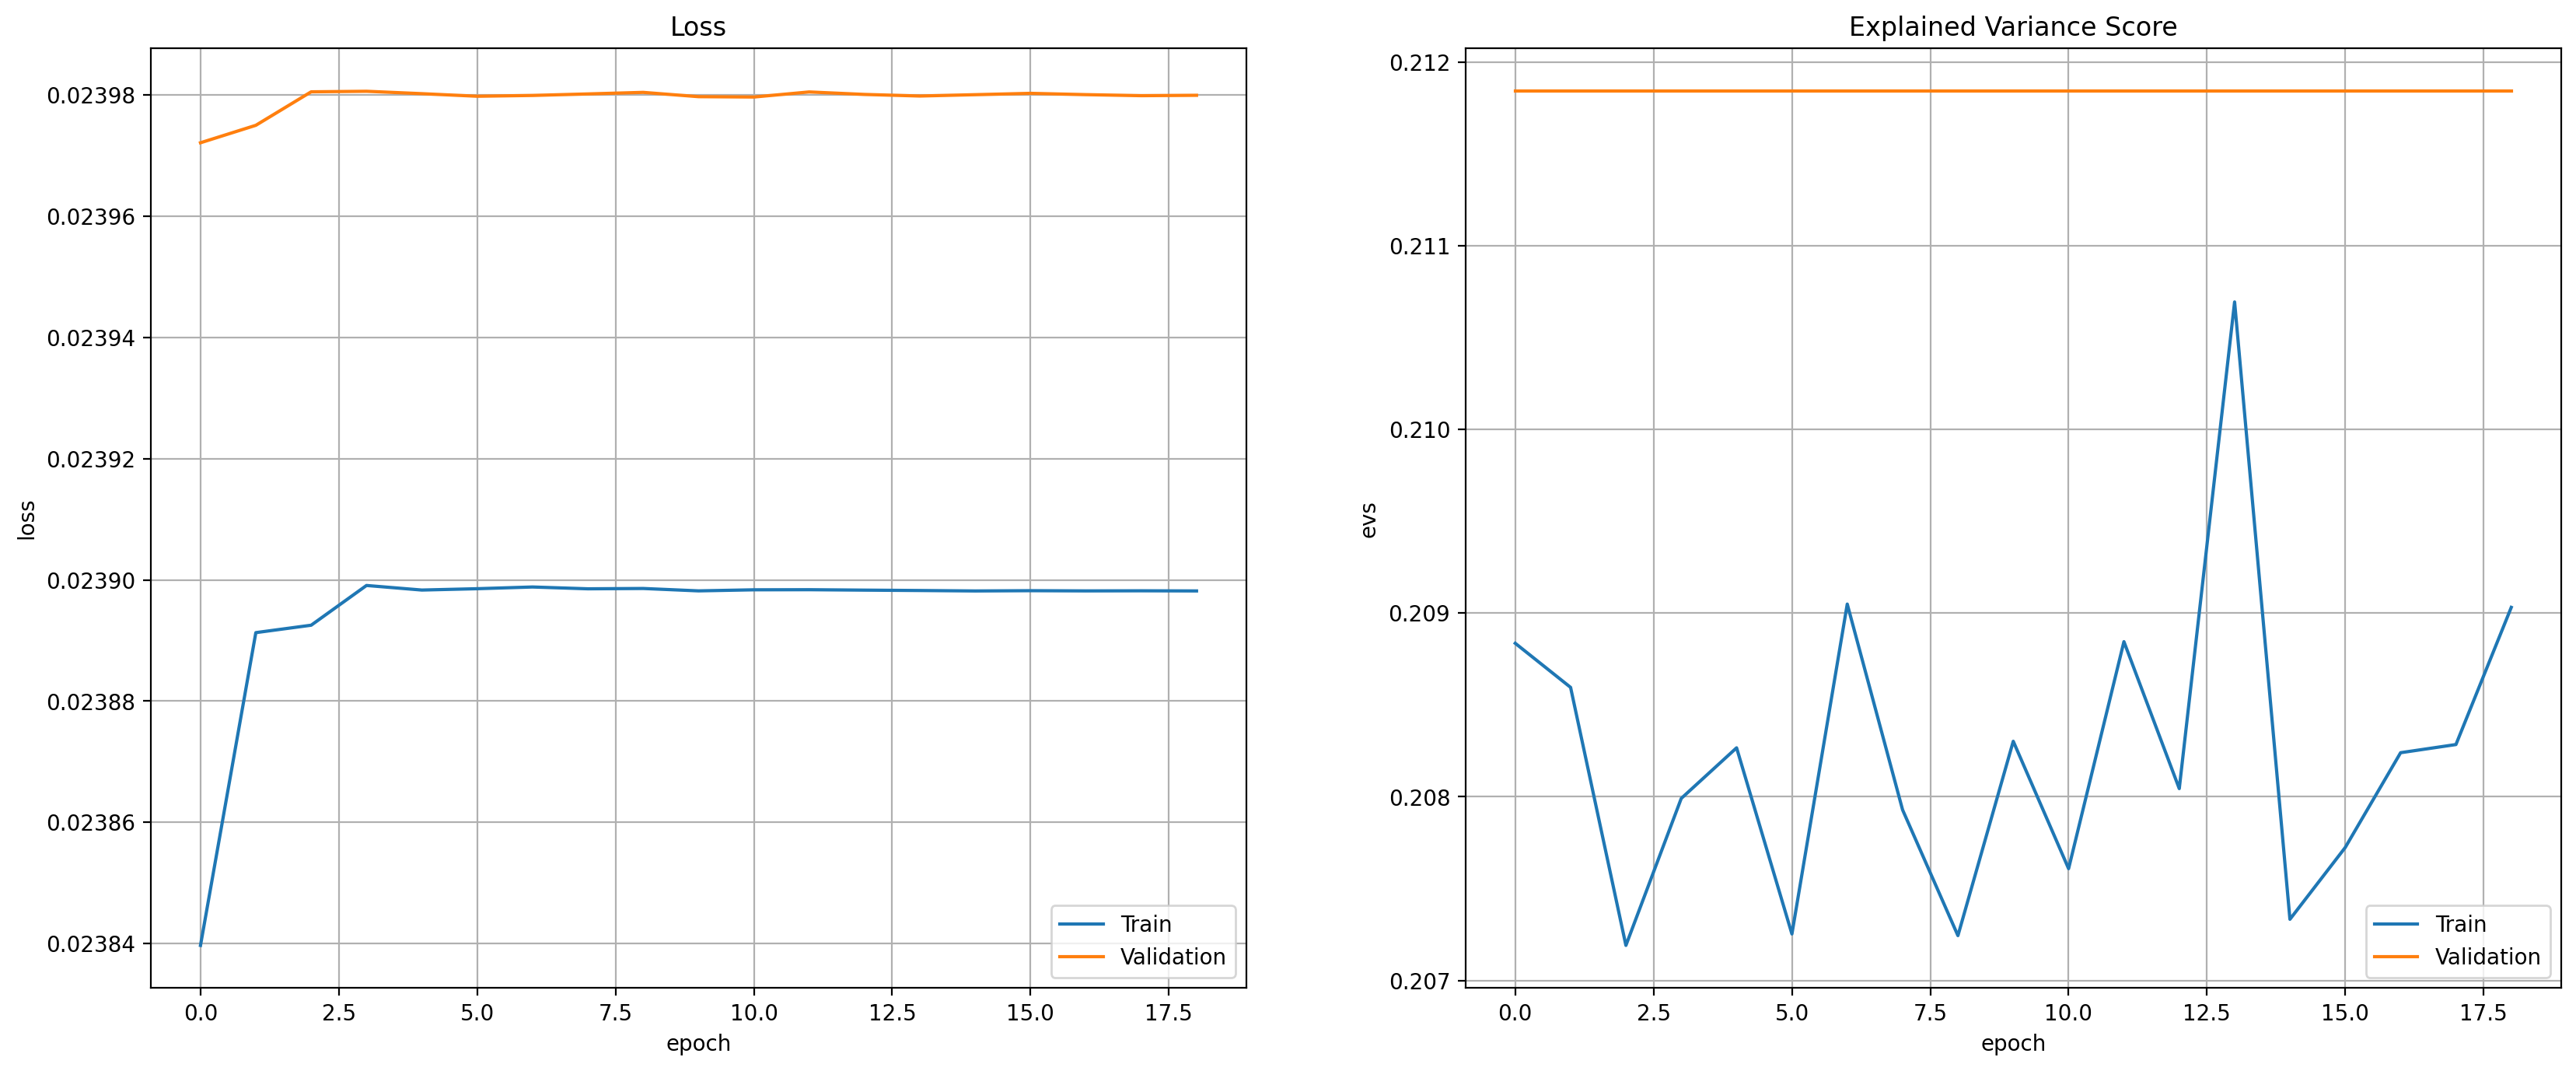

In [ ]:
fig = plt.figure(dpi=200, figsize=(20,8))
ax = plt.subplot(121)
ax.plot(CNNTrainLossCVRP[2:], label="Train")
ax.plot(CNNValLossCVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(CNNTrainEVSCVRP[2:], label="Train")
ax.plot(CNNValEVSCVRP[2:], label="Validation")
ax.legend()
ax.grid(True)
ax.set_title("Explained Variance Score")
ax.set_ylabel('evs')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [ ]:
torch.save(CNN_CVRPmodel.state_dict(), path["CNNmodelCVRP"])

### Graph Neural Network

#### Tratamiento de datos

Partición del dataset en train y test

##### VRP

In [16]:
dataGNNVRP = [generarGrafoVRP(matrices[i], aristasVRP[i])
              for i in range(numInstancias)]

X_VRP = [torch_geometric.utils.convert.from_networkx(dataGNNVRP[i][0]) for i in range(numInstancias)]
y_VRP = np.array([dataGNNVRP[i][1] for i in range(numInstancias)])

X_trainVRP, X_testVRP, y_trainVRP, y_testVRP = train_test_split(X_VRP, y_VRP, test_size=0.25, random_state=1)

##### CVRP

In [17]:
dataGNNCVRP = [generarGrafoCVRP(matrices[i], aristasCVRP[i], demandas[i], capacidades[i])
              for i in range(numInstancias)]

X_CVRP = [torch_geometric.utils.convert.from_networkx(dataGNNCVRP[i][0]) for i in range(numInstancias)]
y_CVRP = np.array([dataGNNCVRP[i][1] for i in range(numInstancias)])

X_trainCVRP, X_testCVRP, y_trainCVRP, y_testCVRP = train_test_split(X_CVRP, y_CVRP, test_size=0.25, random_state=1)

#### Crear dataset específico para el modelo

Creación de la clase Dataset para la manipulación de los datos

In [18]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self, X, y):
      self.X = X
      self.y = torch.from_numpy(y).float().cuda()
   def __len__(self):
      return len(self.X)
   def __getitem__(self, ix):
      transformation = torch_geometric.transforms.ToDevice(device)
      Xtransformed = transformation(self.X[ix])
      return Xtransformed, self.y[ix]

In [19]:
datasetVRP = {
   'train': Dataset(X_trainVRP, y_trainVRP),
   'test': Dataset(X_testVRP, y_testVRP)
}

datasetCVRP = {
   'train': Dataset(X_trainCVRP, y_trainCVRP),
   'test': Dataset(X_testCVRP, y_testCVRP)
 }

Se divide el dataset en batches para un mejor entrenamiento usando el modulo utils.data.

In [95]:
dataloaderVRP = {
   'train': torch_geometric.loader.DataLoader(datasetVRP['train'], batch_size=5, shuffle=True),
   'test': torch_geometric.loader.DataLoader(datasetVRP['test'], batch_size=5, shuffle=False)
}

dataloaderCVRP = {
   'train': torch_geometric.loader.DataLoader(datasetCVRP['train'], batch_size=5, shuffle=True),
   'test': torch_geometric.loader.DataLoader(datasetCVRP['test'], batch_size=5, shuffle=False)
}

#### Definición del modelo

In [161]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = torch_geometric.nn.Sequential("x, edge_index, weight", [
                        (torch_geometric.nn.GCNConv(in_channels, hidden_channels), "x, edge_index, weight -> x1"),
                        torch.nn.ReLU(),
                     ])
        self.conv2 = torch_geometric.nn.Sequential("x, edge_index, weight", [
                        (torch_geometric.nn.GCNConv(hidden_channels, hidden_channels), "x, edge_index, weight -> x1"),
                        torch.nn.ReLU(),
                     ])
        self.conv3 = torch_geometric.nn.Sequential("x, edge_index, weight", [
                        (torch_geometric.nn.GCNConv(hidden_channels, hidden_channels), "x, edge_index, weight -> x1"),
                        torch.nn.ReLU(),
                     ])
        self.conv4 = torch_geometric.nn.Sequential("x, edge_index, weight", [
                        (torch_geometric.nn.GCNConv(hidden_channels, hidden_channels), "x, edge_index, weight -> x1"),
                        torch.nn.ReLU(),
                     ])
        self.conv5 = torch_geometric.nn.GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index, weight):
        x = self.conv1(x, edge_index, weight)
        x = self.conv2(x, edge_index, weight)
        x = self.conv3(x, edge_index, weight)
        x = self.conv4(x, edge_index, weight)
        x = self.conv5(x, edge_index, weight)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

#### Función de entrenamiento

In [162]:
def fit(model, dataloader, epochs):
   model.to(device)
   optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.2)
   criterion = torch.nn.BCEWithLogitsLoss()
   GNNTrainLossMean, GNNValLossMean, GNNTrainEVSMean, GNNValEVSMean = [0.0], [0.0], [0.0], [0.0]
   for epoch in range(1, epochs+1):
      model.train()
      GNNTrainLoss, GNNTrainEVS = [], []
      batches = dataloader['train']
      for batch in batches:
         X, y = batch
         X, y = X.to(device), y.to(device)
         optimizer.zero_grad()
         y_hat = model.encode(X.x, X.edge_index, X.weight)
         y_hat = model.decode(y_hat, X.edge_index).view(y.shape)
         loss = criterion(y_hat, y)
         loss.backward()
         optimizer.step()
         GNNTrainLoss.append(loss.item())
         evs = explained_variance_score(y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())
         GNNTrainEVS.append(evs)
      batches = dataloader['test']
      GNNValLoss, GNNValEVS = [], []
      model.eval()
      with torch.no_grad():
         for batch in batches:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model.encode(X.x, X.edge_index, X.weight)
            y_hat = model.decode(y_hat, X.edge_index).view(y.shape)
            loss = criterion(y_hat, y)
            GNNValLoss.append(loss.item())
            evs = explained_variance_score(y.cpu().numpy(), y_hat.cpu().numpy())
            GNNValEVS.append(evs)
      scheduler.step()
      GNNTrainLossMean.append(np.mean(GNNTrainLoss))
      GNNValLossMean.append(np.mean(GNNValLoss))
      GNNTrainEVSMean.append(np.mean(GNNTrainEVS))
      GNNValEVSMean.append(np.mean(GNNValEVS))
      print(f"Epoch {epoch}/{epochs} loss {GNNTrainLossMean[-1]:.6f} val_loss {GNNValLossMean[-1]:.6f} EVS {GNNTrainEVSMean[-1]:.5f} val_EVS {GNNValEVSMean[-1]:.5f}")
   return GNNTrainLossMean, GNNValLossMean, GNNTrainEVSMean, GNNValEVSMean

#### VRP

##### Instanciación del modelo

In [171]:
GNN_VRPmodel = GNN(2, 3, 1)
GNN_VRPmodel

GNN(
  (conv1): Sequential(
    (0): GCNConv(2, 3)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): GCNConv(3, 3)
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): GCNConv(3, 3)
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): GCNConv(3, 3)
    (1): ReLU()
  )
  (conv5): GCNConv(3, 1)
)

##### Entrenamiento

In [172]:
epochs = 8

GNNTrainLossVRP, GNNValLossVRP, GNNTrainEVSVRP, GNNValEVSVRP = fit(GNN_VRPmodel,
                                                                   dataloaderVRP,
                                                                   epochs=epochs)

Epoch 1/8 loss 0.884949 val_loss 0.693147 EVS 0.67362 val_EVS 0.79853
Epoch 2/8 loss 0.693147 val_loss 0.693147 EVS 0.79735 val_EVS 0.79853
Epoch 3/8 loss 0.693147 val_loss 0.693147 EVS 0.79860 val_EVS 0.79853
Epoch 4/8 loss 0.693147 val_loss 0.693147 EVS 0.79850 val_EVS 0.79853
Epoch 5/8 loss 0.693147 val_loss 0.693147 EVS 0.79832 val_EVS 0.79853
Epoch 6/8 loss 0.693147 val_loss 0.693147 EVS 0.79849 val_EVS 0.79853
Epoch 7/8 loss 0.693147 val_loss 0.693147 EVS 0.79836 val_EVS 0.79853
Epoch 8/8 loss 0.693147 val_loss 0.693147 EVS 0.79835 val_EVS 0.79853


##### Gráficas de métricas

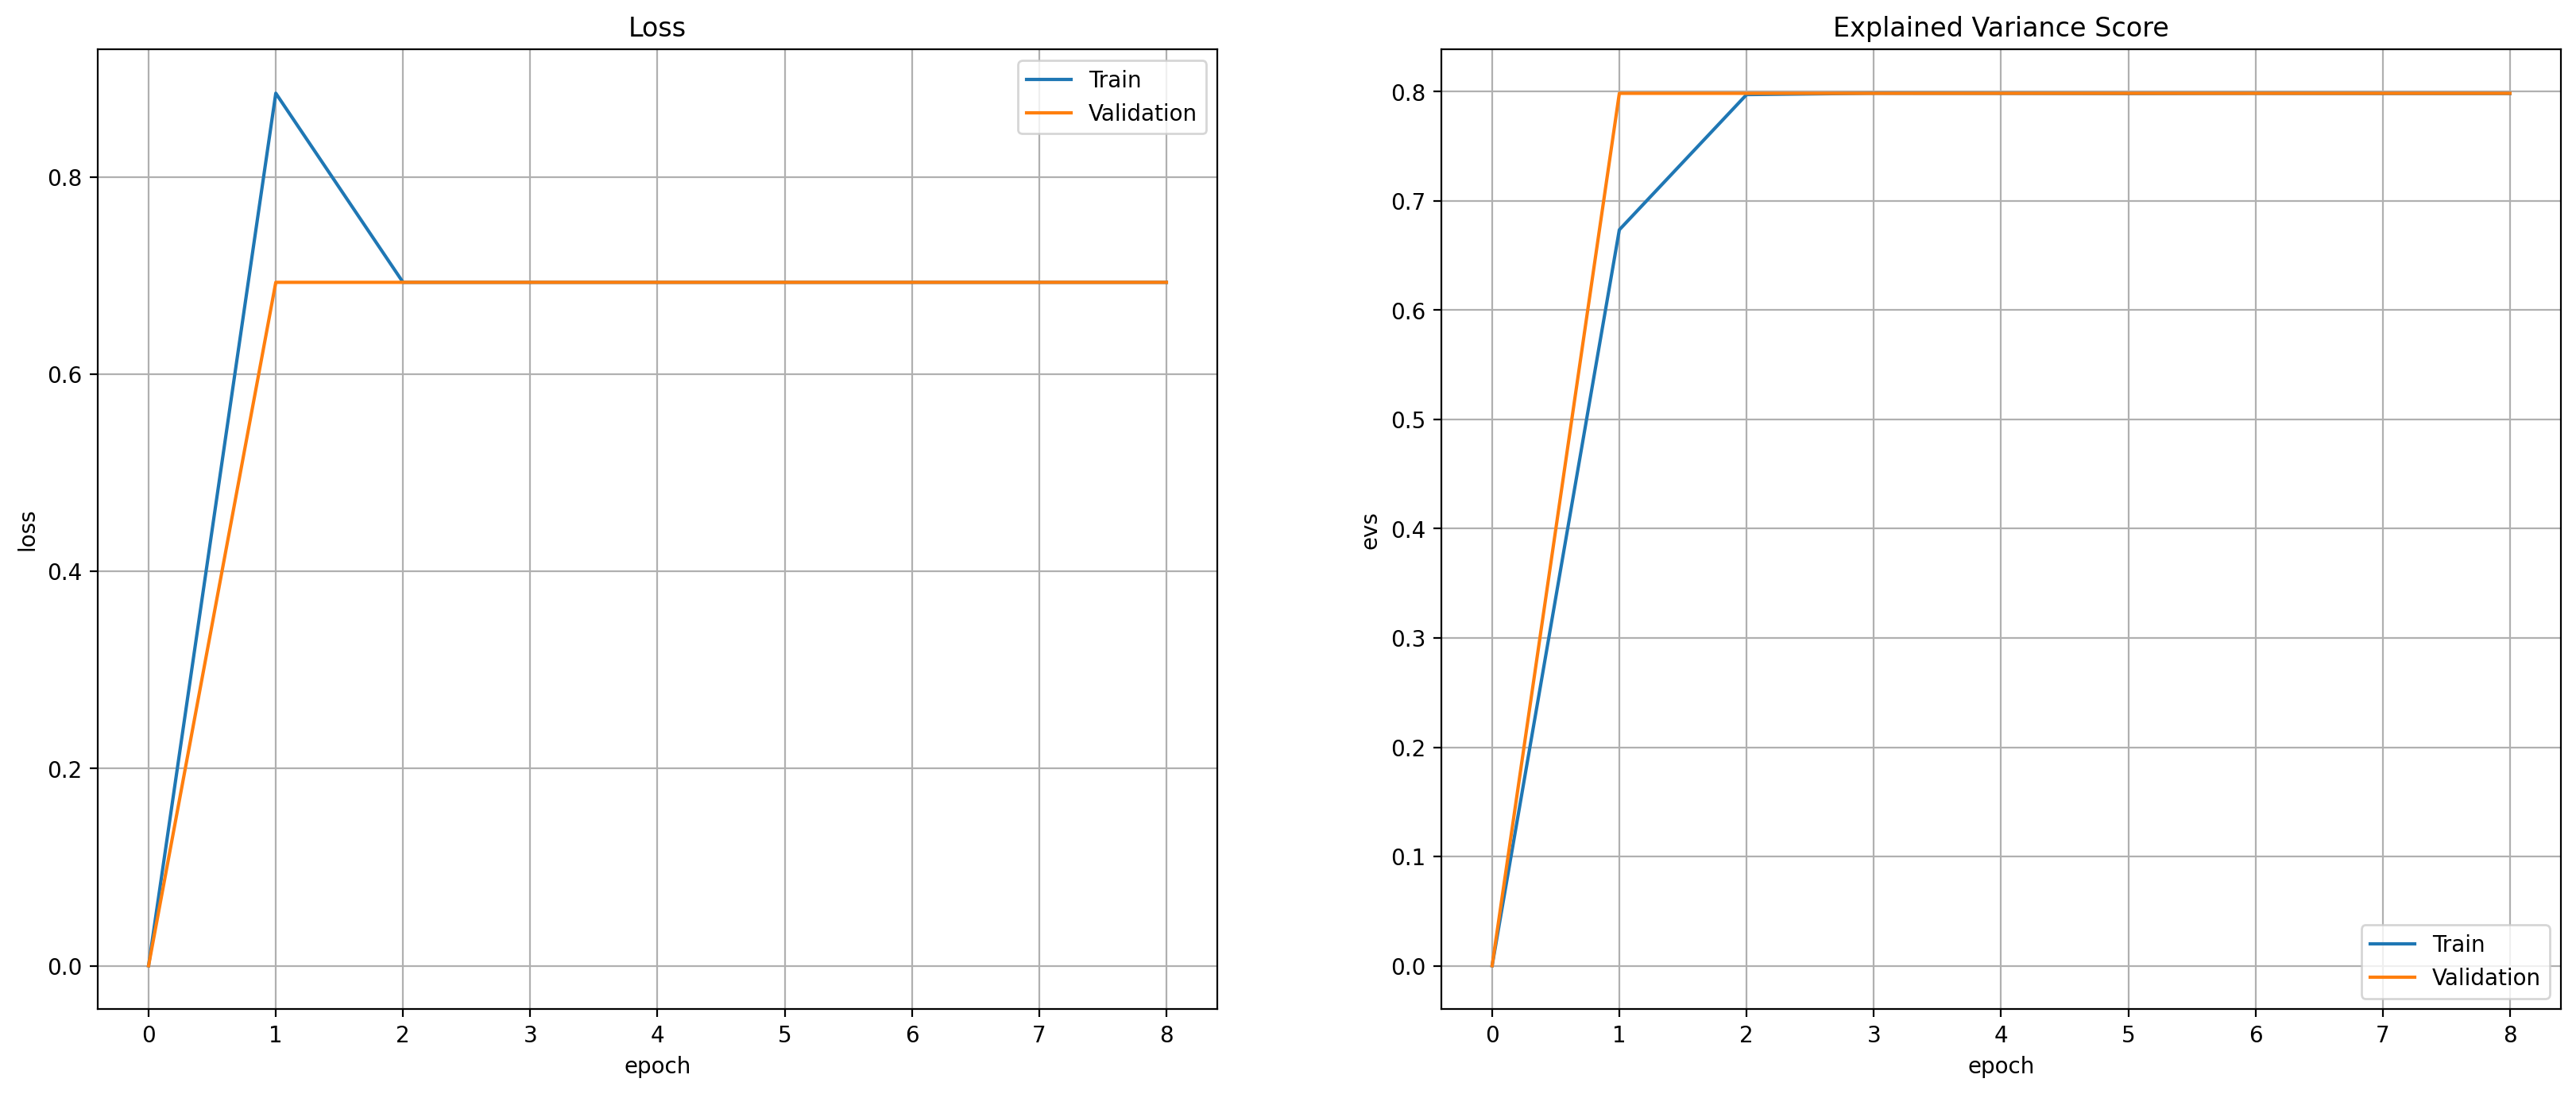

In [173]:
fig = plt.figure(dpi=200, figsize=(20,8))
ax = plt.subplot(121)
ax.plot(GNNTrainLossVRP, label="Train")
ax.plot(GNNValLossVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(GNNTrainEVSVRP, label="Train")
ax.plot(GNNValEVSVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title("Explained Variance Score")
ax.set_ylabel('evs')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [183]:
torch.save(GNN_VRPmodel.state_dict(), path["GNNmodelVRP"])

#### CVRP

##### Instanciación del modelo

In [177]:
GNN_CVRPmodel = GNN(7, 6, 1)
GNN_CVRPmodel

GNN(
  (conv1): Sequential(
    (0): GCNConv(7, 6)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): GCNConv(6, 6)
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): GCNConv(6, 6)
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): GCNConv(6, 6)
    (1): ReLU()
  )
  (conv5): GCNConv(6, 1)
)

##### Entrenamiento

In [178]:
epochs = 10

GNNTrainLossCVRP, GNNValLossCVRP, GNNTrainEVSCVRP, GNNValEVSCVRP = fit(GNN_CVRPmodel,
                                                                   dataloaderCVRP,
                                                                   epochs=epochs)

Epoch 1/10 loss 0.716908 val_loss 0.693147 EVS 0.65522 val_EVS 0.79716
Epoch 2/10 loss 0.693147 val_loss 0.693147 EVS 0.79693 val_EVS 0.79716
Epoch 3/10 loss 0.693147 val_loss 0.693147 EVS 0.79694 val_EVS 0.79716
Epoch 4/10 loss 0.693147 val_loss 0.693147 EVS 0.79718 val_EVS 0.79716
Epoch 5/10 loss 0.693147 val_loss 0.693147 EVS 0.79717 val_EVS 0.79716
Epoch 6/10 loss 0.693147 val_loss 0.693147 EVS 0.79705 val_EVS 0.79716
Epoch 7/10 loss 0.693147 val_loss 0.693147 EVS 0.79722 val_EVS 0.79716
Epoch 8/10 loss 0.693147 val_loss 0.693147 EVS 0.79693 val_EVS 0.79716
Epoch 9/10 loss 0.693147 val_loss 0.693147 EVS 0.79677 val_EVS 0.79716
Epoch 10/10 loss 0.693147 val_loss 0.693147 EVS 0.79698 val_EVS 0.79716


##### Gráficas de métricas

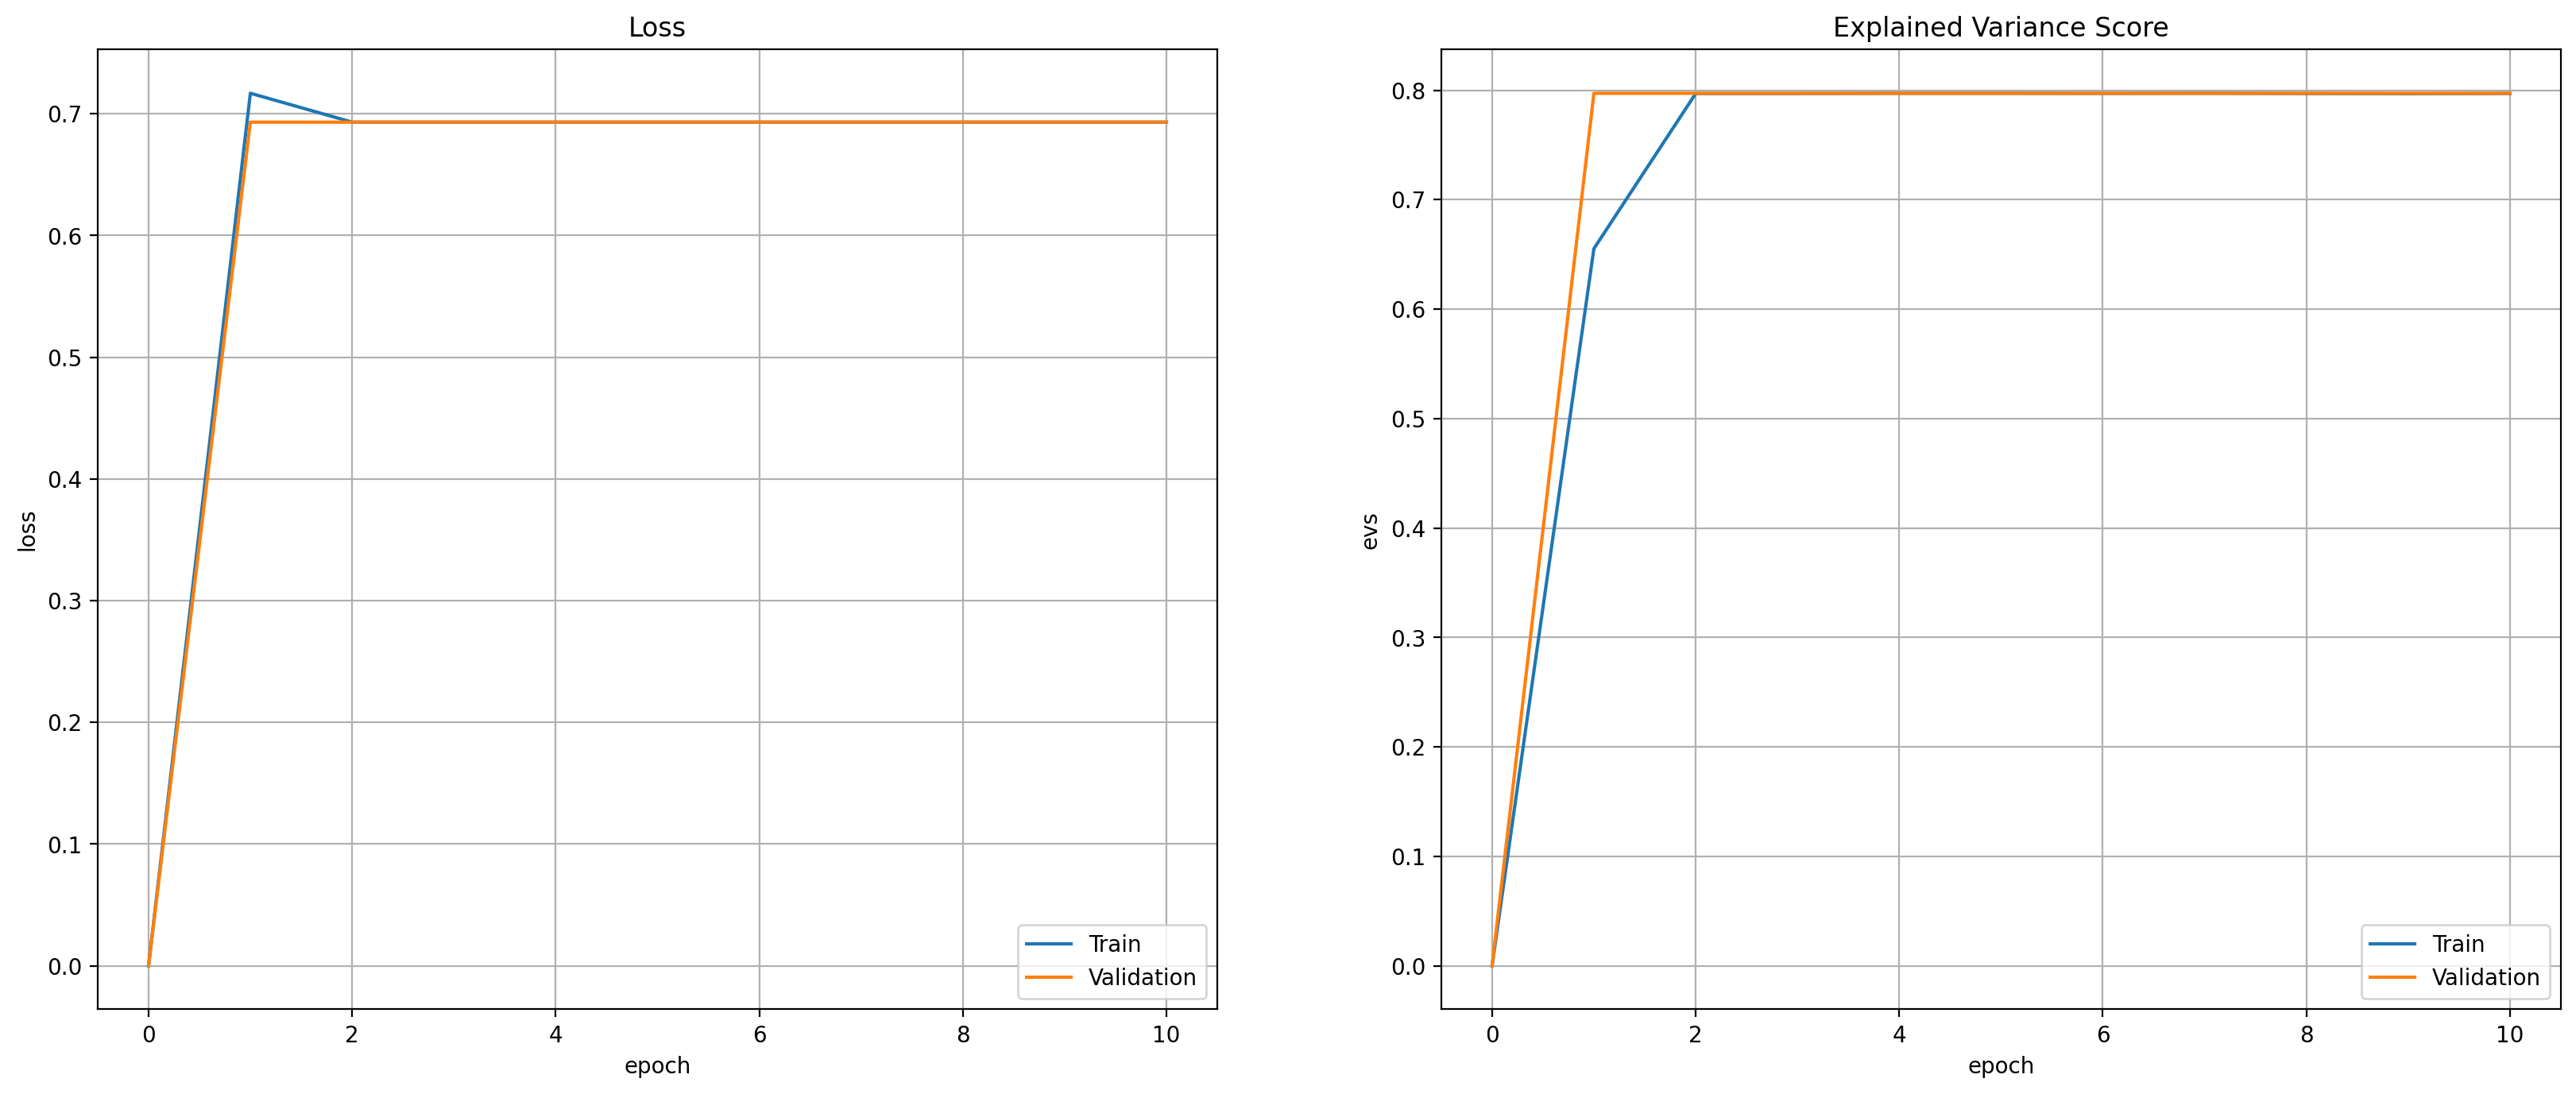

In [180]:
fig = plt.figure(dpi=200, figsize=(20,8))
ax = plt.subplot(121)
ax.plot(GNNTrainLossCVRP, label="Train")
ax.plot(GNNValLossCVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(GNNTrainEVSCVRP, label="Train")
ax.plot(GNNValEVSCVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title("Explained Variance Score")
ax.set_ylabel('evs')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [182]:
torch.save(GNN_VRPmodel.state_dict(), path["GNNmodelCVRP"])